###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
71,Armenia,2013,4.277,9.276,0.723,65.52,0.504,-0.201,0.900,0.503,0.450
1648,Peru,2006,4.811,8.979,0.875,66.46,0.668,-0.076,0.895,0.675,0.420
1255,Madagascar,2014,3.676,7.314,0.655,56.06,0.529,-0.026,0.791,0.641,0.192
1482,Netherlands,2005,7.464,10.809,0.947,70.70,0.901,NaN,0.571,0.701,0.233
212,Bolivia,2007,5.628,8.698,0.796,61.10,0.780,-0.004,0.817,0.746,0.388


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_34564\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


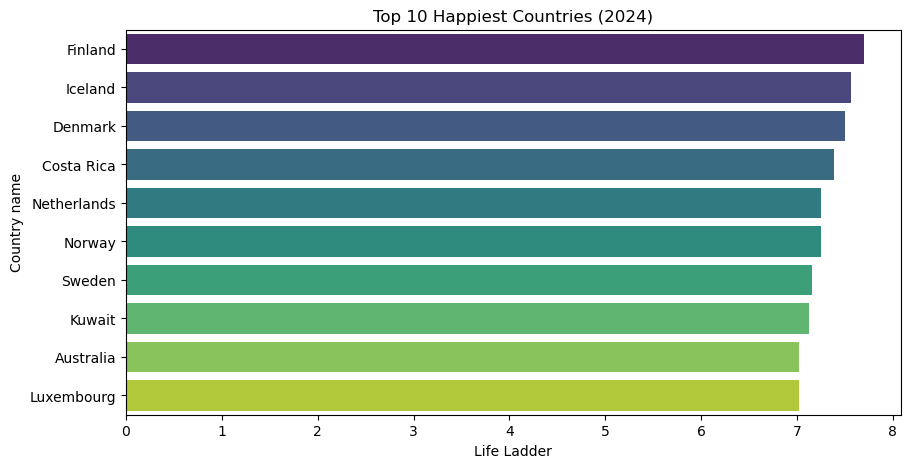

C:\Users\Sohin\AppData\Local\Temp\ipykernel_34564\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


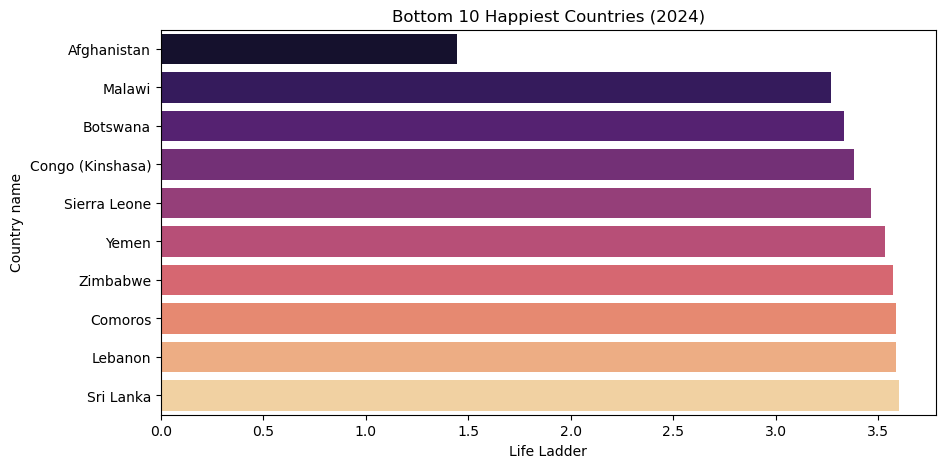

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


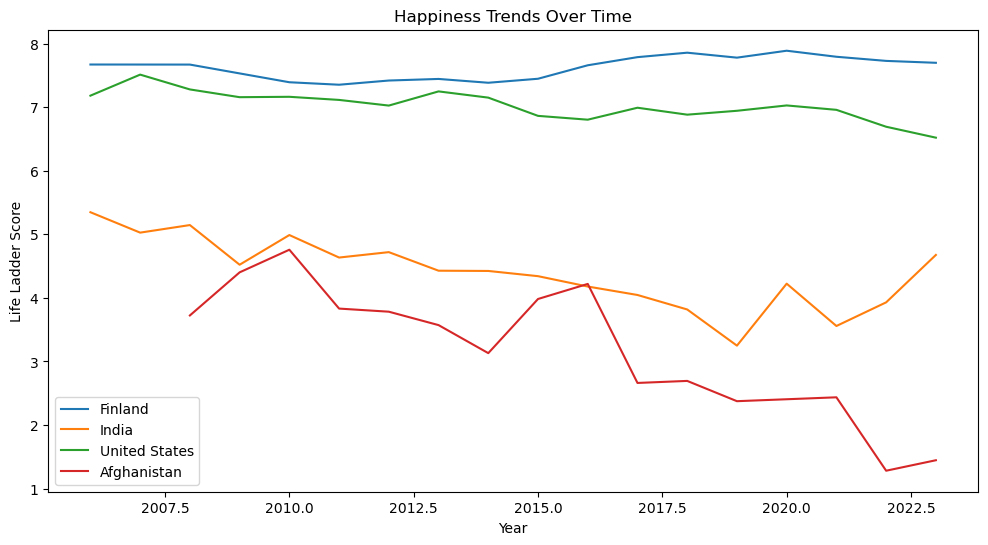

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


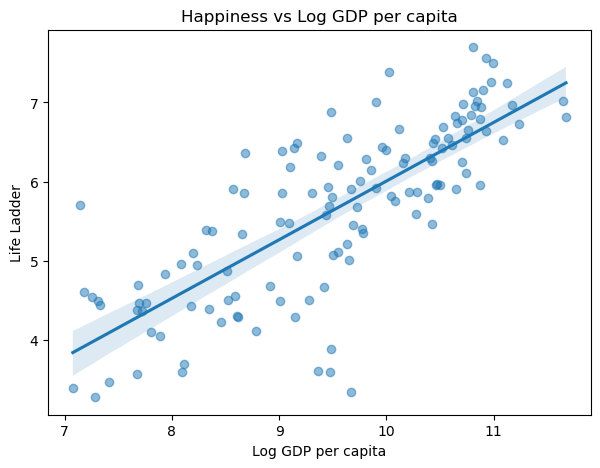

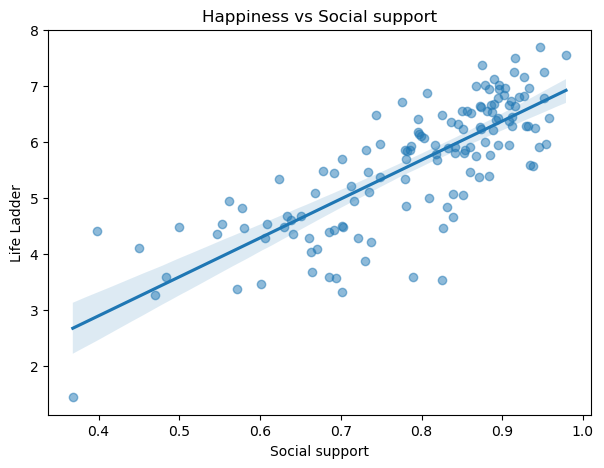

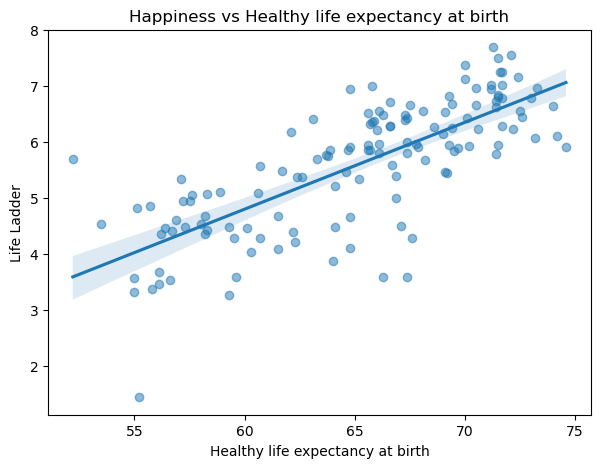

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


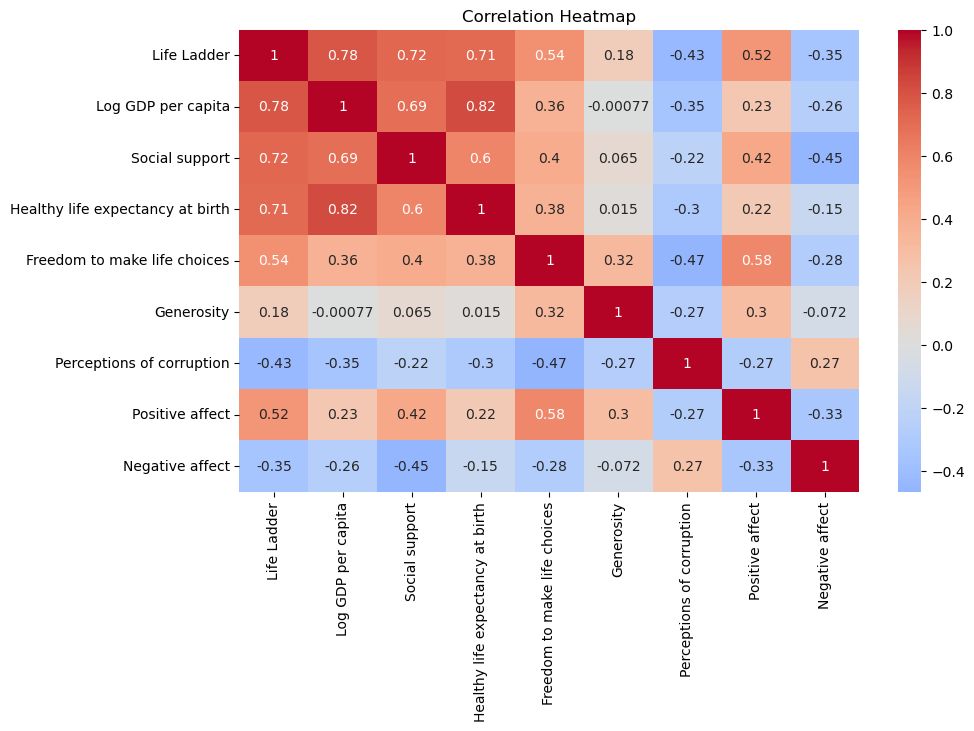

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


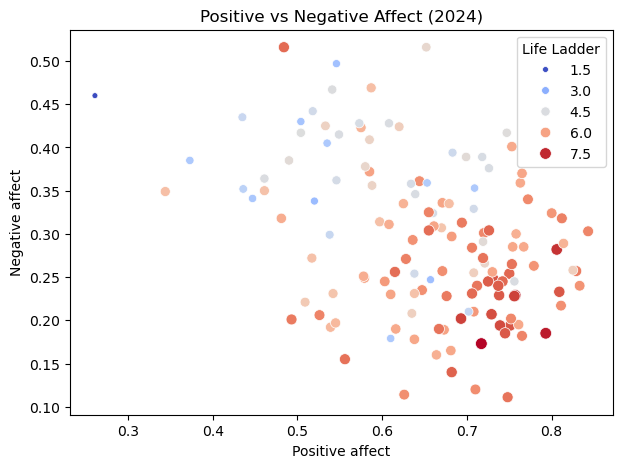

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
data.sample(50)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
114,Azerbaijan,2006,4.728,9.154,0.854,60.580,0.772,-0.239,0.774,0.469,0.276,8
1394,Mongolia,2014,4.825,9.315,0.943,59.480,0.752,0.140,0.909,0.512,0.170,93
906,Indonesia,2007,5.101,8.888,0.704,60.540,0.603,0.307,0.960,0.696,0.242,62
1472,Nepal,2014,4.975,8.056,0.786,60.140,0.712,0.108,0.841,0.492,0.287,99
1548,Niger,2022,4.501,7.151,0.587,56.550,0.793,0.024,0.740,0.787,0.366,103
162,Belarus,2008,5.463,9.677,0.904,61.180,0.640,-0.226,0.696,0.523,0.246,11
74,Armenia,2016,4.325,9.357,0.709,66.275,0.611,-0.178,0.921,0.516,0.437,5
516,Cyprus,2016,5.795,10.510,0.786,71.800,0.756,-0.036,0.898,0.631,0.336,35
1876,Slovenia,2017,6.167,10.505,0.928,70.350,0.921,-0.031,0.829,0.582,0.286,124
1950,Sri Lanka,2008,4.431,9.040,0.816,63.240,0.834,0.156,0.861,0.656,0.153,129


Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1725 non-null   object 
 1   year                              1725 non-null   int64  
 2   Life Ladder                       1725 non-null   float64
 3   Log GDP per capita                1725 non-null   float64
 4   Social support                    1725 non-null   float64
 5   Healthy life expectancy at birth  1725 non-null   float64
 6   Freedom to make life choices      1725 non-null   float64
 7   Generosity                        1725 non-null   float64
 8   Perceptions of corruption         1725 non-null   float64
 9   Positive affect                   1725 non-null   float64
 10  Negative affect                   1725 non-null   float64
 11  country_label                     1725 non-null   int16  
dtypes: float64(

In [26]:
features_train = training.drop(['Life Ladder', 'Country name'], axis=1)
features_test = test.drop(['Life Ladder', 'Country name'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']

# features_train = training.drop(['Life Ladder'], axis=1)
# features_test = test.drop(['Life Ladder'], axis=1)
# target_train = training['Life Ladder']
# target_test = test['Life Ladder']


# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [27]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3925387796713835

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [28]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-29 21:21:23,182] A new study created in memory with name: no-name-57ba6eed-9cba-44d0-b7a0-7cb09bbbfad4
[I 2025-09-29 21:21:23,371] Trial 0 finished with value: 0.3423942584461636 and parameters: {'n_estimators': 20, 'max_depth': 9}. Best is trial 0 with value: 0.3423942584461636.
[I 2025-09-29 21:21:24,178] Trial 1 finished with value: 0.3398588251689124 and parameters: {'n_estimators': 150, 'max_depth': 9}. Best is trial 1 with value: 0.3398588251689124.
[I 2025-09-29 21:21:24,480] Trial 2 finished with value: 0.36240104593171013 and parameters: {'n_estimators': 150, 'max_depth': 7}. Best is trial 1 with value: 0.3398588251689124.
[I 2025-09-29 21:21:24,568] Trial 3 finished with value: 0.37864254898873595 and parameters: {'n_estimators': 70, 'max_depth': 6}. Best is trial 1 with value: 0.3398588251689124.
[I 2025-09-29 21:21:24,583] Trial 4 finished with value: 0.48203909030793207 and parameters: {'n_estimators': 30, 'max_depth': 2}. Best is trial 1 with value: 0.339858825

In [29]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 30, 'max_depth': 13}
At trial:  25
Mean absolute error:  0.3163441164342185

Hyperparameter importances:


{'max_depth': 0.9528684175200934, 'n_estimators': 0.04713158247990662}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [30]:
from sklearn.ensemble import RandomForestRegressor

rtf = RandomForestRegressor()
rtf.fit(features_train, target_train)
rtf_pred = rtf.predict(features_test)
rtf_mae = mean_absolute_error(target_test, rtf_pred)
rtf_mae


0.3258767658730158

In [31]:
from sklearn.tree import DecisionTreeRegressor

dtr= DecisionTreeRegressor()
dtr.fit(features_train, target_train)
dtr_pred = rtf.predict(features_test)
dtr_mae = mean_absolute_error(target_test, dtr_pred)
dtr_mae


0.3258767658730158

In [32]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_pred)
lgbm_mae

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 10
[LightGBM] [Info] Start training from score 5.448597


c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.3077101680480545

In [33]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
cbr.fit(features_train, target_train)
cbr_pred = cbr.predict(features_test)
cbr_mae = mean_absolute_error(target_test, cbr_pred)
cbr_mae

Learning rate set to 0.044626
0:	learn: 1.0963346	total: 148ms	remaining: 2m 27s
1:	learn: 1.0612144	total: 152ms	remaining: 1m 15s
2:	learn: 1.0278523	total: 155ms	remaining: 51.5s
3:	learn: 0.9969295	total: 159ms	remaining: 39.5s
4:	learn: 0.9668442	total: 162ms	remaining: 32.3s
5:	learn: 0.9395862	total: 166ms	remaining: 27.5s
6:	learn: 0.9135088	total: 170ms	remaining: 24.1s
7:	learn: 0.8885151	total: 173ms	remaining: 21.5s
8:	learn: 0.8644008	total: 178ms	remaining: 19.6s
9:	learn: 0.8415540	total: 183ms	remaining: 18.1s
10:	learn: 0.8191188	total: 187ms	remaining: 16.8s
11:	learn: 0.7982412	total: 191ms	remaining: 15.7s
12:	learn: 0.7780339	total: 195ms	remaining: 14.8s
13:	learn: 0.7612855	total: 199ms	remaining: 14s
14:	learn: 0.7434443	total: 203ms	remaining: 13.3s
15:	learn: 0.7261445	total: 207ms	remaining: 12.8s
16:	learn: 0.7112221	total: 211ms	remaining: 12.2s
17:	learn: 0.6965188	total: 215ms	remaining: 11.7s
18:	learn: 0.6837074	total: 218ms	remaining: 11.3s
19:	learn: 

0.29024782039418323

In [34]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-29 21:21:56,486] A new study created in memory with name: no-name-ca347190-36f4-437e-94af-bfb4c73b508e


Learning rate set to 0.17991
0:	learn: 1.0131870	total: 1.15ms	remaining: 206ms
1:	learn: 0.9192804	total: 2.19ms	remaining: 195ms
2:	learn: 0.8365244	total: 3.87ms	remaining: 229ms
3:	learn: 0.7656877	total: 4.62ms	remaining: 203ms
4:	learn: 0.7194328	total: 5.74ms	remaining: 201ms
5:	learn: 0.6769546	total: 6.51ms	remaining: 189ms
6:	learn: 0.6418763	total: 7.21ms	remaining: 178ms
7:	learn: 0.6137476	total: 7.96ms	remaining: 171ms
8:	learn: 0.5954331	total: 8.6ms	remaining: 163ms
9:	learn: 0.5743653	total: 9.69ms	remaining: 165ms
10:	learn: 0.5595372	total: 10.3ms	remaining: 158ms
11:	learn: 0.5478823	total: 11.1ms	remaining: 155ms
12:	learn: 0.5371293	total: 11.8ms	remaining: 152ms
13:	learn: 0.5292344	total: 12.7ms	remaining: 150ms
14:	learn: 0.5208332	total: 13.3ms	remaining: 146ms
15:	learn: 0.5142185	total: 14.3ms	remaining: 147ms
16:	learn: 0.5095971	total: 14.9ms	remaining: 143ms
17:	learn: 0.5060274	total: 15.6ms	remaining: 141ms
18:	learn: 0.5021241	total: 16.6ms	remaining: 

[I 2025-09-29 21:21:56,754] Trial 0 finished with value: 0.35153622568060167 and parameters: {'n_estimators': 180, 'max_depth': 2}. Best is trial 0 with value: 0.35153622568060167.


Learning rate set to 0.268497
0:	learn: 0.9237280	total: 6.5ms	remaining: 709ms
1:	learn: 0.7793622	total: 11.4ms	remaining: 616ms
2:	learn: 0.6712773	total: 16.1ms	remaining: 574ms
3:	learn: 0.6001278	total: 20.7ms	remaining: 548ms
4:	learn: 0.5435699	total: 24.3ms	remaining: 510ms
5:	learn: 0.5050195	total: 27.9ms	remaining: 483ms
6:	learn: 0.4823874	total: 31.7ms	remaining: 466ms
7:	learn: 0.4654165	total: 36.5ms	remaining: 466ms
8:	learn: 0.4542654	total: 40.3ms	remaining: 452ms
9:	learn: 0.4366913	total: 44.6ms	remaining: 446ms
10:	learn: 0.4285088	total: 48.8ms	remaining: 440ms
11:	learn: 0.4192913	total: 53.1ms	remaining: 433ms
12:	learn: 0.4127525	total: 56.8ms	remaining: 424ms
13:	learn: 0.4061014	total: 60ms	remaining: 411ms
14:	learn: 0.3999482	total: 63.3ms	remaining: 401ms
15:	learn: 0.3935064	total: 67.1ms	remaining: 394ms
16:	learn: 0.3908018	total: 70.6ms	remaining: 386ms
17:	learn: 0.3833205	total: 74.1ms	remaining: 379ms
18:	learn: 0.3796047	total: 77.2ms	remaining: 3

[I 2025-09-29 21:21:57,288] Trial 1 finished with value: 0.3106210790155225 and parameters: {'n_estimators': 110, 'max_depth': 7}. Best is trial 1 with value: 0.3106210790155225.


101:	learn: 0.1710036	total: 371ms	remaining: 29.1ms
102:	learn: 0.1696485	total: 377ms	remaining: 25.6ms
103:	learn: 0.1683262	total: 380ms	remaining: 21.9ms
104:	learn: 0.1672909	total: 384ms	remaining: 18.3ms
105:	learn: 0.1663228	total: 389ms	remaining: 14.7ms
106:	learn: 0.1655818	total: 393ms	remaining: 11ms
107:	learn: 0.1644309	total: 396ms	remaining: 7.34ms
108:	learn: 0.1630317	total: 400ms	remaining: 3.67ms
109:	learn: 0.1614730	total: 403ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7682750	total: 6.11ms	remaining: 177ms
1:	learn: 0.5855687	total: 12.1ms	remaining: 169ms
2:	learn: 0.4937218	total: 19.3ms	remaining: 173ms
3:	learn: 0.4574913	total: 26.1ms	remaining: 170ms
4:	learn: 0.4351367	total: 32.1ms	remaining: 161ms
5:	learn: 0.4172718	total: 37.7ms	remaining: 151ms
6:	learn: 0.3995549	total: 45.2ms	remaining: 149ms
7:	learn: 0.3812686	total: 51ms	remaining: 140ms
8:	learn: 0.3670546	total: 57.9ms	remaining: 135ms
9:	learn: 0.3580410	total: 63.8ms	remaining: 1

[I 2025-09-29 21:21:57,585] Trial 2 finished with value: 0.35096366156684955 and parameters: {'n_estimators': 30, 'max_depth': 8}. Best is trial 1 with value: 0.3106210790155225.


11:	learn: 0.3445386	total: 76.3ms	remaining: 114ms
12:	learn: 0.3351033	total: 83ms	remaining: 109ms
13:	learn: 0.3291681	total: 92ms	remaining: 105ms
14:	learn: 0.3192643	total: 98.2ms	remaining: 98.2ms
15:	learn: 0.3132262	total: 105ms	remaining: 92.2ms
16:	learn: 0.3075460	total: 111ms	remaining: 85ms
17:	learn: 0.3026538	total: 116ms	remaining: 77.5ms
18:	learn: 0.2928338	total: 123ms	remaining: 71.1ms
19:	learn: 0.2839212	total: 129ms	remaining: 64.4ms
20:	learn: 0.2762448	total: 136ms	remaining: 58.3ms
21:	learn: 0.2717051	total: 143ms	remaining: 52ms
22:	learn: 0.2642354	total: 150ms	remaining: 45.6ms
23:	learn: 0.2601190	total: 156ms	remaining: 39.1ms
24:	learn: 0.2529710	total: 162ms	remaining: 32.5ms
25:	learn: 0.2475882	total: 169ms	remaining: 26ms
26:	learn: 0.2427118	total: 175ms	remaining: 19.4ms
27:	learn: 0.2354628	total: 181ms	remaining: 12.9ms
28:	learn: 0.2296198	total: 187ms	remaining: 6.46ms
29:	learn: 0.2252377	total: 193ms	remaining: 0us
Learning rate set to 0.1

[I 2025-09-29 21:21:58,266] Trial 3 finished with value: 0.30236574850573567 and parameters: {'n_estimators': 190, 'max_depth': 6}. Best is trial 3 with value: 0.30236574850573567.


129:	learn: 0.2284804	total: 367ms	remaining: 169ms
130:	learn: 0.2279531	total: 370ms	remaining: 167ms
131:	learn: 0.2270166	total: 373ms	remaining: 164ms
132:	learn: 0.2258626	total: 375ms	remaining: 161ms
133:	learn: 0.2251100	total: 377ms	remaining: 158ms
134:	learn: 0.2246950	total: 380ms	remaining: 155ms
135:	learn: 0.2244511	total: 382ms	remaining: 152ms
136:	learn: 0.2230117	total: 385ms	remaining: 149ms
137:	learn: 0.2222721	total: 387ms	remaining: 146ms
138:	learn: 0.2209647	total: 390ms	remaining: 143ms
139:	learn: 0.2205839	total: 392ms	remaining: 140ms
140:	learn: 0.2200502	total: 394ms	remaining: 137ms
141:	learn: 0.2188064	total: 397ms	remaining: 134ms
142:	learn: 0.2184412	total: 399ms	remaining: 131ms
143:	learn: 0.2173597	total: 402ms	remaining: 128ms
144:	learn: 0.2158542	total: 404ms	remaining: 125ms
145:	learn: 0.2150127	total: 406ms	remaining: 122ms
146:	learn: 0.2137884	total: 409ms	remaining: 120ms
147:	learn: 0.2128495	total: 411ms	remaining: 117ms
148:	learn: 

[I 2025-09-29 21:21:59,104] Trial 4 finished with value: 0.30226890211239194 and parameters: {'n_estimators': 180, 'max_depth': 7}. Best is trial 4 with value: 0.30226890211239194.


152:	learn: 0.1684883	total: 583ms	remaining: 103ms
153:	learn: 0.1670594	total: 587ms	remaining: 99.1ms
154:	learn: 0.1667467	total: 591ms	remaining: 95.4ms
155:	learn: 0.1661081	total: 595ms	remaining: 91.6ms
156:	learn: 0.1651943	total: 599ms	remaining: 87.8ms
157:	learn: 0.1646438	total: 602ms	remaining: 83.9ms
158:	learn: 0.1636573	total: 606ms	remaining: 80ms
159:	learn: 0.1632398	total: 609ms	remaining: 76.2ms
160:	learn: 0.1623339	total: 613ms	remaining: 72.4ms
161:	learn: 0.1616151	total: 617ms	remaining: 68.5ms
162:	learn: 0.1604603	total: 620ms	remaining: 64.6ms
163:	learn: 0.1601952	total: 623ms	remaining: 60.8ms
164:	learn: 0.1592370	total: 627ms	remaining: 57ms
165:	learn: 0.1585732	total: 631ms	remaining: 53.2ms
166:	learn: 0.1579680	total: 635ms	remaining: 49.4ms
167:	learn: 0.1571626	total: 638ms	remaining: 45.6ms
168:	learn: 0.1567489	total: 642ms	remaining: 41.8ms
169:	learn: 0.1563765	total: 645ms	remaining: 38ms
170:	learn: 0.1554910	total: 648ms	remaining: 34.1ms


[I 2025-09-29 21:22:11,938] Trial 5 pruned. 


109:	learn: 0.0337308	total: 12.5s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 1.0011917	total: 1.75ms	remaining: 330ms
1:	learn: 0.8966418	total: 2.71ms	remaining: 255ms
2:	learn: 0.8112003	total: 3.83ms	remaining: 239ms
3:	learn: 0.7499070	total: 4.54ms	remaining: 211ms
4:	learn: 0.7035712	total: 5.47ms	remaining: 202ms
5:	learn: 0.6602454	total: 7.01ms	remaining: 215ms
6:	learn: 0.6240577	total: 7.84ms	remaining: 205ms
7:	learn: 0.5948740	total: 8.81ms	remaining: 200ms
8:	learn: 0.5719893	total: 10.1ms	remaining: 202ms
9:	learn: 0.5553923	total: 10.7ms	remaining: 192ms
10:	learn: 0.5434757	total: 11.6ms	remaining: 189ms
11:	learn: 0.5315566	total: 13.2ms	remaining: 195ms
12:	learn: 0.5230446	total: 14.2ms	remaining: 194ms
13:	learn: 0.5152427	total: 15.6ms	remaining: 196ms
14:	learn: 0.5071439	total: 17.6ms	remaining: 205ms
15:	learn: 0.5031015	total: 18.7ms	remaining: 204ms
16:	learn: 0.4984206	total: 19.9ms	remaining: 203ms
17:	learn: 0.4941073	total: 21.3ms	remaining: 

[I 2025-09-29 21:22:12,289] Trial 6 pruned. 


145:	learn: 0.3436557	total: 165ms	remaining: 49.9ms
146:	learn: 0.3427470	total: 167ms	remaining: 49ms
147:	learn: 0.3421940	total: 169ms	remaining: 47.9ms
148:	learn: 0.3416601	total: 170ms	remaining: 46.7ms
149:	learn: 0.3407248	total: 171ms	remaining: 45.7ms
150:	learn: 0.3399524	total: 173ms	remaining: 44.6ms
151:	learn: 0.3393521	total: 174ms	remaining: 43.4ms
152:	learn: 0.3387300	total: 175ms	remaining: 42.2ms
153:	learn: 0.3381387	total: 176ms	remaining: 41.1ms
154:	learn: 0.3376206	total: 177ms	remaining: 40ms
155:	learn: 0.3365083	total: 178ms	remaining: 38.9ms
156:	learn: 0.3364539	total: 179ms	remaining: 37.7ms
157:	learn: 0.3360331	total: 180ms	remaining: 36.5ms
158:	learn: 0.3351271	total: 181ms	remaining: 35.3ms
159:	learn: 0.3345872	total: 182ms	remaining: 34.2ms
160:	learn: 0.3339987	total: 183ms	remaining: 33ms
161:	learn: 0.3334762	total: 184ms	remaining: 31.8ms
162:	learn: 0.3326164	total: 185ms	remaining: 30.6ms
163:	learn: 0.3324349	total: 186ms	remaining: 29.5ms

[I 2025-09-29 21:22:13,011] Trial 7 pruned. 


Learning rate set to 0.5
0:	learn: 0.7818653	total: 25.1ms	remaining: 226ms
1:	learn: 0.5956325	total: 44.4ms	remaining: 178ms
2:	learn: 0.4950025	total: 65ms	remaining: 152ms
3:	learn: 0.4495255	total: 86ms	remaining: 129ms
4:	learn: 0.4146156	total: 105ms	remaining: 105ms
5:	learn: 0.3919211	total: 125ms	remaining: 83.5ms
6:	learn: 0.3695164	total: 145ms	remaining: 62.2ms
7:	learn: 0.3462037	total: 168ms	remaining: 42ms
8:	learn: 0.3292379	total: 187ms	remaining: 20.8ms


[I 2025-09-29 21:22:13,321] Trial 8 pruned. 


9:	learn: 0.3154571	total: 205ms	remaining: 0us
Learning rate set to 0.268497
0:	learn: 0.9202355	total: 9.41ms	remaining: 1.02s
1:	learn: 0.7732021	total: 11.6ms	remaining: 626ms
2:	learn: 0.6685491	total: 13.4ms	remaining: 480ms
3:	learn: 0.6015107	total: 16.2ms	remaining: 428ms
4:	learn: 0.5515157	total: 18.8ms	remaining: 395ms
5:	learn: 0.5155007	total: 23.3ms	remaining: 403ms
6:	learn: 0.4930305	total: 27.2ms	remaining: 400ms
7:	learn: 0.4787295	total: 29.5ms	remaining: 376ms
8:	learn: 0.4650018	total: 32ms	remaining: 359ms
9:	learn: 0.4564463	total: 34.3ms	remaining: 343ms
10:	learn: 0.4485855	total: 37.9ms	remaining: 341ms
11:	learn: 0.4381538	total: 41.5ms	remaining: 339ms
12:	learn: 0.4307638	total: 45.5ms	remaining: 339ms
13:	learn: 0.4263637	total: 48.2ms	remaining: 331ms
14:	learn: 0.4217491	total: 52.3ms	remaining: 331ms
15:	learn: 0.4181269	total: 55.9ms	remaining: 329ms
16:	learn: 0.4129966	total: 58.2ms	remaining: 318ms
17:	learn: 0.4101796	total: 60.6ms	remaining: 310m

[I 2025-09-29 21:22:13,719] Trial 9 pruned. 


109:	learn: 0.1946623	total: 289ms	remaining: 0us
Learning rate set to 0.439496
0:	learn: 0.8627730	total: 736ms	remaining: 43.4s
1:	learn: 0.6761448	total: 1.23s	remaining: 35.7s
2:	learn: 0.5443986	total: 1.7s	remaining: 32.2s
3:	learn: 0.4529089	total: 2.17s	remaining: 30.4s
4:	learn: 0.3899097	total: 2.61s	remaining: 28.7s
5:	learn: 0.3432645	total: 3.06s	remaining: 27.5s
6:	learn: 0.3066573	total: 3.5s	remaining: 26.5s
7:	learn: 0.2744669	total: 3.92s	remaining: 25.5s
8:	learn: 0.2476992	total: 4.34s	remaining: 24.6s
9:	learn: 0.2274112	total: 4.76s	remaining: 23.8s
10:	learn: 0.2087314	total: 5.19s	remaining: 23.1s
11:	learn: 0.1955629	total: 5.61s	remaining: 22.5s
12:	learn: 0.1808434	total: 6.02s	remaining: 21.8s
13:	learn: 0.1698370	total: 6.42s	remaining: 21.1s
14:	learn: 0.1608368	total: 6.82s	remaining: 20.4s
15:	learn: 0.1516957	total: 7.2s	remaining: 19.8s
16:	learn: 0.1435216	total: 7.6s	remaining: 19.2s
17:	learn: 0.1370433	total: 8.01s	remaining: 18.7s
18:	learn: 0.130

[I 2025-09-29 21:22:39,723] Trial 10 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9759836	total: 3.87ms	remaining: 615ms
1:	learn: 0.8576310	total: 6.69ms	remaining: 528ms
2:	learn: 0.7635964	total: 8.68ms	remaining: 455ms
3:	learn: 0.6914273	total: 11.3ms	remaining: 441ms
4:	learn: 0.6372935	total: 14.2ms	remaining: 439ms
5:	learn: 0.5990980	total: 18.3ms	remaining: 470ms
6:	learn: 0.5637189	total: 20.1ms	remaining: 439ms
7:	learn: 0.5410993	total: 22.3ms	remaining: 424ms
8:	learn: 0.5213622	total: 23.9ms	remaining: 401ms
9:	learn: 0.5070002	total: 25.4ms	remaining: 380ms
10:	learn: 0.4963892	total: 26.7ms	remaining: 361ms
11:	learn: 0.4884931	total: 28ms	remaining: 345ms
12:	learn: 0.4817111	total: 29.2ms	remaining: 330ms
13:	learn: 0.4754769	total: 30.4ms	remaining: 317ms
14:	learn: 0.4708737	total: 31.7ms	remaining: 306ms
15:	learn: 0.4671282	total: 33.1ms	remaining: 298ms
16:	learn: 0.4627169	total: 34.3ms	remaining: 289ms
17:	learn: 0.4584609	total: 35.4ms	remaining: 280ms
18:	learn: 0.4553789	total: 36.7ms	remaining: 2

[I 2025-09-29 21:22:40,095] Trial 11 pruned. 


128:	learn: 0.2892462	total: 183ms	remaining: 44ms
129:	learn: 0.2883384	total: 185ms	remaining: 42.6ms
130:	learn: 0.2873651	total: 186ms	remaining: 41.2ms
131:	learn: 0.2865544	total: 188ms	remaining: 39.8ms
132:	learn: 0.2859002	total: 189ms	remaining: 38.4ms
133:	learn: 0.2850728	total: 190ms	remaining: 36.9ms
134:	learn: 0.2840938	total: 191ms	remaining: 35.5ms
135:	learn: 0.2834002	total: 193ms	remaining: 34.1ms
136:	learn: 0.2830282	total: 195ms	remaining: 32.7ms
137:	learn: 0.2820478	total: 196ms	remaining: 31.3ms
138:	learn: 0.2811111	total: 198ms	remaining: 29.9ms
139:	learn: 0.2801694	total: 199ms	remaining: 28.4ms
140:	learn: 0.2795365	total: 200ms	remaining: 27ms
141:	learn: 0.2791378	total: 201ms	remaining: 25.5ms
142:	learn: 0.2784083	total: 203ms	remaining: 24.1ms
143:	learn: 0.2774334	total: 204ms	remaining: 22.6ms
144:	learn: 0.2766671	total: 205ms	remaining: 21.2ms
145:	learn: 0.2762204	total: 206ms	remaining: 19.8ms
146:	learn: 0.2755764	total: 207ms	remaining: 18.3

[I 2025-09-29 21:22:44,532] Trial 12 pruned. 


197:	learn: 0.0654677	total: 4.15s	remaining: 41.9ms
198:	learn: 0.0648295	total: 4.17s	remaining: 21ms
199:	learn: 0.0644020	total: 4.19s	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9774713	total: 20.7ms	remaining: 3.08s
1:	learn: 0.8461457	total: 46.7ms	remaining: 3.45s
2:	learn: 0.7419791	total: 68.2ms	remaining: 3.34s
3:	learn: 0.6709656	total: 88.3ms	remaining: 3.22s
4:	learn: 0.6055426	total: 108ms	remaining: 3.14s
5:	learn: 0.5543208	total: 131ms	remaining: 3.13s
6:	learn: 0.5131555	total: 150ms	remaining: 3.07s
7:	learn: 0.4795380	total: 171ms	remaining: 3.03s
8:	learn: 0.4507721	total: 190ms	remaining: 2.97s
9:	learn: 0.4291806	total: 211ms	remaining: 2.96s
10:	learn: 0.4108316	total: 231ms	remaining: 2.92s
11:	learn: 0.3972158	total: 252ms	remaining: 2.9s
12:	learn: 0.3834845	total: 272ms	remaining: 2.87s
13:	learn: 0.3691986	total: 292ms	remaining: 2.84s
14:	learn: 0.3551253	total: 313ms	remaining: 2.82s
15:	learn: 0.3479790	total: 333ms	remaining: 2.79s
16:	lea

[I 2025-09-29 21:22:47,789] Trial 13 pruned. 


149:	learn: 0.0688362	total: 3.04s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9828419	total: 2.6ms	remaining: 440ms
1:	learn: 0.8645394	total: 4.58ms	remaining: 385ms
2:	learn: 0.7756559	total: 6.28ms	remaining: 350ms
3:	learn: 0.7039066	total: 7.86ms	remaining: 326ms
4:	learn: 0.6467855	total: 9.6ms	remaining: 317ms
5:	learn: 0.6084997	total: 11.3ms	remaining: 309ms
6:	learn: 0.5713214	total: 13.5ms	remaining: 313ms
7:	learn: 0.5423922	total: 15.4ms	remaining: 313ms
8:	learn: 0.5235986	total: 17.7ms	remaining: 316ms
9:	learn: 0.5093630	total: 19.9ms	remaining: 318ms
10:	learn: 0.4975518	total: 21.6ms	remaining: 312ms
11:	learn: 0.4891413	total: 23.4ms	remaining: 308ms
12:	learn: 0.4823199	total: 25.2ms	remaining: 304ms
13:	learn: 0.4754477	total: 27.1ms	remaining: 302ms
14:	learn: 0.4700352	total: 29.3ms	remaining: 303ms
15:	learn: 0.4621095	total: 31.7ms	remaining: 305ms
16:	learn: 0.4573637	total: 34.1ms	remaining: 307ms
17:	learn: 0.4534399	total: 36ms	remaining: 304m

[I 2025-09-29 21:22:48,219] Trial 14 pruned. 


148:	learn: 0.2388276	total: 268ms	remaining: 37.8ms
149:	learn: 0.2384434	total: 270ms	remaining: 36ms
150:	learn: 0.2376662	total: 272ms	remaining: 34.2ms
151:	learn: 0.2369835	total: 273ms	remaining: 32.4ms
152:	learn: 0.2368347	total: 275ms	remaining: 30.6ms
153:	learn: 0.2363830	total: 277ms	remaining: 28.8ms
154:	learn: 0.2358458	total: 279ms	remaining: 27ms
155:	learn: 0.2352356	total: 280ms	remaining: 25.2ms
156:	learn: 0.2348423	total: 282ms	remaining: 23.4ms
157:	learn: 0.2337295	total: 284ms	remaining: 21.6ms
158:	learn: 0.2329391	total: 286ms	remaining: 19.8ms
159:	learn: 0.2319329	total: 288ms	remaining: 18ms
160:	learn: 0.2312406	total: 290ms	remaining: 16.2ms
161:	learn: 0.2308159	total: 291ms	remaining: 14.4ms
162:	learn: 0.2301615	total: 293ms	remaining: 12.6ms
163:	learn: 0.2291204	total: 295ms	remaining: 10.8ms
164:	learn: 0.2283609	total: 297ms	remaining: 8.99ms
165:	learn: 0.2275724	total: 299ms	remaining: 7.2ms
166:	learn: 0.2267471	total: 301ms	remaining: 5.4ms
1

[I 2025-09-29 21:22:48,437] Trial 15 pruned. 


63:	learn: 0.4773365	total: 47.6ms	remaining: 56.6ms
64:	learn: 0.4770025	total: 48.9ms	remaining: 56.4ms
65:	learn: 0.4766011	total: 49.4ms	remaining: 55.4ms
66:	learn: 0.4761693	total: 50.4ms	remaining: 54.9ms
67:	learn: 0.4757962	total: 51ms	remaining: 54ms
68:	learn: 0.4754555	total: 51.7ms	remaining: 53.2ms
69:	learn: 0.4751443	total: 52.5ms	remaining: 52.5ms
70:	learn: 0.4748277	total: 53.2ms	remaining: 51.7ms
71:	learn: 0.4746195	total: 53.8ms	remaining: 50.8ms
72:	learn: 0.4742847	total: 54.4ms	remaining: 49.9ms
73:	learn: 0.4740139	total: 54.9ms	remaining: 49ms
74:	learn: 0.4737078	total: 55.5ms	remaining: 48.1ms
75:	learn: 0.4734170	total: 56.1ms	remaining: 47.3ms
76:	learn: 0.4730188	total: 56.8ms	remaining: 46.5ms
77:	learn: 0.4727302	total: 57.3ms	remaining: 45.6ms
78:	learn: 0.4724059	total: 57.8ms	remaining: 44.7ms
79:	learn: 0.4720678	total: 58.3ms	remaining: 43.7ms
80:	learn: 0.4718482	total: 58.8ms	remaining: 42.8ms
81:	learn: 0.4715565	total: 59.3ms	remaining: 42ms
8

[I 2025-09-29 21:22:48,704] Trial 16 pruned. 


16:	learn: 0.4265308	total: 38ms	remaining: 141ms
17:	learn: 0.4227353	total: 40ms	remaining: 138ms
18:	learn: 0.4143027	total: 42.2ms	remaining: 136ms
19:	learn: 0.4104821	total: 43.9ms	remaining: 132ms
20:	learn: 0.4046120	total: 45.6ms	remaining: 128ms
21:	learn: 0.3986903	total: 47.6ms	remaining: 126ms
22:	learn: 0.3951480	total: 49.7ms	remaining: 123ms
23:	learn: 0.3916569	total: 53.7ms	remaining: 125ms
24:	learn: 0.3879800	total: 55.2ms	remaining: 121ms
25:	learn: 0.3809107	total: 56.6ms	remaining: 117ms
26:	learn: 0.3759331	total: 58ms	remaining: 114ms
27:	learn: 0.3700361	total: 59.3ms	remaining: 110ms
28:	learn: 0.3643854	total: 60.7ms	remaining: 107ms
29:	learn: 0.3613810	total: 62.2ms	remaining: 104ms
30:	learn: 0.3556578	total: 64.3ms	remaining: 102ms
31:	learn: 0.3524326	total: 66ms	remaining: 99.1ms
32:	learn: 0.3500856	total: 67.9ms	remaining: 96.7ms
33:	learn: 0.3461613	total: 70ms	remaining: 94.7ms
34:	learn: 0.3426410	total: 71.6ms	remaining: 92.1ms
35:	learn: 0.34044

[I 2025-09-29 21:23:01,604] Trial 17 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9515634	total: 5.66ms	remaining: 730ms
1:	learn: 0.8242536	total: 10.9ms	remaining: 698ms
2:	learn: 0.7161340	total: 17.4ms	remaining: 735ms
3:	learn: 0.6336059	total: 27.3ms	remaining: 859ms
4:	learn: 0.5723003	total: 33.5ms	remaining: 838ms
5:	learn: 0.5275044	total: 40.7ms	remaining: 840ms
6:	learn: 0.4941239	total: 46ms	remaining: 809ms
7:	learn: 0.4679840	total: 53.1ms	remaining: 810ms
8:	learn: 0.4485112	total: 60.6ms	remaining: 815ms
9:	learn: 0.4345598	total: 66.3ms	remaining: 795ms
10:	learn: 0.4225271	total: 72.8ms	remaining: 787ms
11:	learn: 0.4125387	total: 78.4ms	remaining: 771ms
12:	learn: 0.4006325	total: 85.2ms	remaining: 767ms
13:	learn: 0.3926218	total: 91.3ms	remaining: 757ms
14:	learn: 0.3835720	total: 97.4ms	remaining: 747ms
15:	learn: 0.3773234	total: 104ms	remaining: 741ms
16:	learn: 0.3712610	total: 110ms	remaining: 730ms
17:	learn: 0.3675752	total: 116ms	remaining: 719ms
18:	learn: 0.3627910	total: 123ms	remaining: 717m

[I 2025-09-29 21:23:02,591] Trial 18 pruned. 


123:	learn: 0.1303599	total: 784ms	remaining: 37.9ms
124:	learn: 0.1297382	total: 791ms	remaining: 31.6ms
125:	learn: 0.1287259	total: 798ms	remaining: 25.3ms
126:	learn: 0.1281337	total: 804ms	remaining: 19ms
127:	learn: 0.1272302	total: 809ms	remaining: 12.6ms
128:	learn: 0.1261848	total: 816ms	remaining: 6.32ms
129:	learn: 0.1253170	total: 821ms	remaining: 0us
Learning rate set to 0.34784
0:	learn: 0.8703679	total: 11.3ms	remaining: 889ms
1:	learn: 0.7057851	total: 23.5ms	remaining: 918ms
2:	learn: 0.5969063	total: 35.6ms	remaining: 914ms
3:	learn: 0.5281698	total: 46.5ms	remaining: 883ms
4:	learn: 0.4807156	total: 57.3ms	remaining: 859ms
5:	learn: 0.4517764	total: 69.2ms	remaining: 853ms
6:	learn: 0.4250313	total: 80.8ms	remaining: 843ms
7:	learn: 0.4062648	total: 91.5ms	remaining: 824ms
8:	learn: 0.3887585	total: 102ms	remaining: 802ms
9:	learn: 0.3714668	total: 113ms	remaining: 792ms
10:	learn: 0.3574425	total: 124ms	remaining: 776ms
11:	learn: 0.3479838	total: 133ms	remaining: 7

[I 2025-09-29 21:23:03,611] Trial 19 pruned. 


Learning rate set to 0.188468
0:	learn: 0.9831955	total: 3.03ms	remaining: 512ms
1:	learn: 0.8687798	total: 4.69ms	remaining: 394ms
2:	learn: 0.7767723	total: 6.87ms	remaining: 382ms
3:	learn: 0.7050986	total: 8.83ms	remaining: 367ms
4:	learn: 0.6503326	total: 12ms	remaining: 396ms
5:	learn: 0.6110138	total: 15.5ms	remaining: 423ms
6:	learn: 0.5739849	total: 18.1ms	remaining: 420ms
7:	learn: 0.5500888	total: 20.4ms	remaining: 412ms
8:	learn: 0.5303359	total: 22.4ms	remaining: 400ms
9:	learn: 0.5149066	total: 24.3ms	remaining: 388ms
10:	learn: 0.5030557	total: 26.5ms	remaining: 383ms
11:	learn: 0.4930906	total: 28.7ms	remaining: 378ms
12:	learn: 0.4854947	total: 30.5ms	remaining: 368ms
13:	learn: 0.4795375	total: 31.8ms	remaining: 354ms
14:	learn: 0.4753656	total: 33.3ms	remaining: 344ms
15:	learn: 0.4717078	total: 34.7ms	remaining: 334ms
16:	learn: 0.4669523	total: 36.1ms	remaining: 325ms
17:	learn: 0.4625820	total: 37.4ms	remaining: 316ms
18:	learn: 0.4593362	total: 38.7ms	remaining: 

[I 2025-09-29 21:23:03,976] Trial 20 pruned. 


130:	learn: 0.2907462	total: 186ms	remaining: 55.3ms
131:	learn: 0.2894201	total: 188ms	remaining: 54ms
132:	learn: 0.2889360	total: 189ms	remaining: 52.6ms
133:	learn: 0.2879775	total: 190ms	remaining: 51.1ms
134:	learn: 0.2867767	total: 192ms	remaining: 49.7ms
135:	learn: 0.2866465	total: 193ms	remaining: 48.3ms
136:	learn: 0.2855988	total: 194ms	remaining: 46.8ms
137:	learn: 0.2848929	total: 195ms	remaining: 45.3ms
138:	learn: 0.2842190	total: 197ms	remaining: 43.8ms
139:	learn: 0.2836202	total: 198ms	remaining: 42.4ms
140:	learn: 0.2828216	total: 199ms	remaining: 40.9ms
141:	learn: 0.2817955	total: 200ms	remaining: 39.5ms
142:	learn: 0.2811330	total: 202ms	remaining: 38.1ms
143:	learn: 0.2804943	total: 203ms	remaining: 36.7ms
144:	learn: 0.2792846	total: 205ms	remaining: 35.3ms
145:	learn: 0.2787084	total: 206ms	remaining: 33.9ms
146:	learn: 0.2778293	total: 208ms	remaining: 32.5ms
147:	learn: 0.2768477	total: 209ms	remaining: 31.1ms
148:	learn: 0.2762437	total: 211ms	remaining: 29

[I 2025-09-29 21:23:04,613] Trial 21 finished with value: 0.31013179828620674 and parameters: {'n_estimators': 130, 'max_depth': 7}. Best is trial 4 with value: 0.30226890211239194.


113:	learn: 0.1695166	total: 433ms	remaining: 60.8ms
114:	learn: 0.1685951	total: 438ms	remaining: 57.1ms
115:	learn: 0.1679938	total: 441ms	remaining: 53.3ms
116:	learn: 0.1669751	total: 446ms	remaining: 49.5ms
117:	learn: 0.1664724	total: 450ms	remaining: 45.7ms
118:	learn: 0.1650964	total: 453ms	remaining: 41.9ms
119:	learn: 0.1643926	total: 457ms	remaining: 38ms
120:	learn: 0.1632963	total: 460ms	remaining: 34.3ms
121:	learn: 0.1623752	total: 464ms	remaining: 30.4ms
122:	learn: 0.1612301	total: 468ms	remaining: 26.6ms
123:	learn: 0.1597908	total: 471ms	remaining: 22.8ms
124:	learn: 0.1585243	total: 475ms	remaining: 19ms
125:	learn: 0.1576377	total: 478ms	remaining: 15.2ms
126:	learn: 0.1568267	total: 482ms	remaining: 11.4ms
127:	learn: 0.1552641	total: 485ms	remaining: 7.58ms
128:	learn: 0.1542242	total: 489ms	remaining: 3.79ms
129:	learn: 0.1536926	total: 493ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9811067	total: 4.84ms	remaining: 818ms
1:	learn: 0.8658784	total

[I 2025-09-29 21:23:05,185] Trial 22 finished with value: 0.30979673706769834 and parameters: {'n_estimators': 170, 'max_depth': 6}. Best is trial 4 with value: 0.30226890211239194.


163:	learn: 0.1911961	total: 405ms	remaining: 14.8ms
164:	learn: 0.1903748	total: 407ms	remaining: 12.3ms
165:	learn: 0.1898139	total: 410ms	remaining: 9.87ms
166:	learn: 0.1893372	total: 412ms	remaining: 7.39ms
167:	learn: 0.1884264	total: 414ms	remaining: 4.93ms
168:	learn: 0.1881141	total: 417ms	remaining: 2.46ms
169:	learn: 0.1877965	total: 419ms	remaining: 0us
Learning rate set to 0.17991
0:	learn: 0.9877343	total: 3.69ms	remaining: 660ms
1:	learn: 0.8763146	total: 6.39ms	remaining: 569ms
2:	learn: 0.7838280	total: 9.42ms	remaining: 556ms
3:	learn: 0.7192654	total: 12.1ms	remaining: 531ms
4:	learn: 0.6604911	total: 14.4ms	remaining: 504ms
5:	learn: 0.6138932	total: 17.2ms	remaining: 498ms
6:	learn: 0.5759059	total: 19.7ms	remaining: 488ms
7:	learn: 0.5489737	total: 22.5ms	remaining: 484ms
8:	learn: 0.5272955	total: 25.3ms	remaining: 480ms
9:	learn: 0.5088288	total: 28.3ms	remaining: 482ms
10:	learn: 0.4911330	total: 30.9ms	remaining: 475ms
11:	learn: 0.4780553	total: 34ms	remainin

[I 2025-09-29 21:23:05,776] Trial 23 finished with value: 0.3089197472790466 and parameters: {'n_estimators': 180, 'max_depth': 6}. Best is trial 4 with value: 0.30226890211239194.


Learning rate set to 0.172173
0:	learn: 0.9956066	total: 2.48ms	remaining: 469ms
1:	learn: 0.8883438	total: 4.76ms	remaining: 447ms
2:	learn: 0.8035875	total: 6.73ms	remaining: 419ms
3:	learn: 0.7362573	total: 8.43ms	remaining: 392ms
4:	learn: 0.6798110	total: 12.7ms	remaining: 472ms
5:	learn: 0.6389663	total: 15ms	remaining: 461ms
6:	learn: 0.5992428	total: 16.7ms	remaining: 436ms
7:	learn: 0.5726613	total: 18.9ms	remaining: 430ms
8:	learn: 0.5490835	total: 20.1ms	remaining: 405ms
9:	learn: 0.5302706	total: 21.9ms	remaining: 394ms
10:	learn: 0.5168960	total: 23.6ms	remaining: 384ms
11:	learn: 0.5059585	total: 25.1ms	remaining: 373ms
12:	learn: 0.4969305	total: 26.4ms	remaining: 360ms
13:	learn: 0.4894242	total: 27.7ms	remaining: 349ms
14:	learn: 0.4822854	total: 29.2ms	remaining: 340ms
15:	learn: 0.4772952	total: 30.4ms	remaining: 331ms
16:	learn: 0.4729366	total: 31.6ms	remaining: 322ms
17:	learn: 0.4686205	total: 32.8ms	remaining: 314ms
18:	learn: 0.4656465	total: 34ms	remaining: 30

[I 2025-09-29 21:23:06,180] Trial 24 pruned. 


126:	learn: 0.3093815	total: 178ms	remaining: 88.2ms
127:	learn: 0.3084564	total: 179ms	remaining: 86.8ms
128:	learn: 0.3075593	total: 181ms	remaining: 85.5ms
129:	learn: 0.3065317	total: 182ms	remaining: 84ms
130:	learn: 0.3057169	total: 183ms	remaining: 82.5ms
131:	learn: 0.3047584	total: 184ms	remaining: 81ms
132:	learn: 0.3039486	total: 185ms	remaining: 79.5ms
133:	learn: 0.3028278	total: 187ms	remaining: 77.9ms
134:	learn: 0.3012862	total: 188ms	remaining: 76.4ms
135:	learn: 0.3011181	total: 189ms	remaining: 75ms
136:	learn: 0.3004189	total: 190ms	remaining: 73.5ms
137:	learn: 0.2999285	total: 191ms	remaining: 72.1ms
138:	learn: 0.2993215	total: 193ms	remaining: 70.7ms
139:	learn: 0.2984624	total: 194ms	remaining: 69.3ms
140:	learn: 0.2980960	total: 195ms	remaining: 67.9ms
141:	learn: 0.2974114	total: 197ms	remaining: 66.5ms
142:	learn: 0.2966573	total: 198ms	remaining: 65ms
143:	learn: 0.2957356	total: 199ms	remaining: 63.7ms
144:	learn: 0.2949399	total: 200ms	remaining: 62.2ms
1

[I 2025-09-29 21:23:06,754] Trial 25 finished with value: 0.3089197472790466 and parameters: {'n_estimators': 180, 'max_depth': 6}. Best is trial 4 with value: 0.30226890211239194.


160:	learn: 0.1941556	total: 388ms	remaining: 45.7ms
161:	learn: 0.1935005	total: 390ms	remaining: 43.4ms
162:	learn: 0.1931000	total: 393ms	remaining: 41ms
163:	learn: 0.1928581	total: 395ms	remaining: 38.6ms
164:	learn: 0.1922629	total: 398ms	remaining: 36.2ms
165:	learn: 0.1918950	total: 401ms	remaining: 33.8ms
166:	learn: 0.1914459	total: 403ms	remaining: 31.4ms
167:	learn: 0.1908751	total: 406ms	remaining: 29ms
168:	learn: 0.1899237	total: 408ms	remaining: 26.6ms
169:	learn: 0.1892979	total: 411ms	remaining: 24.2ms
170:	learn: 0.1885870	total: 413ms	remaining: 21.7ms
171:	learn: 0.1882531	total: 416ms	remaining: 19.3ms
172:	learn: 0.1872638	total: 418ms	remaining: 16.9ms
173:	learn: 0.1866393	total: 421ms	remaining: 14.5ms
174:	learn: 0.1860673	total: 423ms	remaining: 12.1ms
175:	learn: 0.1852411	total: 425ms	remaining: 9.66ms
176:	learn: 0.1845766	total: 428ms	remaining: 7.25ms
177:	learn: 0.1842247	total: 430ms	remaining: 4.83ms
178:	learn: 0.1836787	total: 432ms	remaining: 2.42

[I 2025-09-29 21:23:08,335] Trial 26 finished with value: 0.3068755281765068 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 4 with value: 0.30226890211239194.


Learning rate set to 0.172173
0:	learn: 0.9984130	total: 8.69ms	remaining: 1.64s
1:	learn: 0.8897394	total: 22.9ms	remaining: 2.15s
2:	learn: 0.7956616	total: 35.9ms	remaining: 2.24s
3:	learn: 0.7219904	total: 48.1ms	remaining: 2.23s
4:	learn: 0.6589713	total: 57.7ms	remaining: 2.13s
5:	learn: 0.6071095	total: 69.1ms	remaining: 2.12s
6:	learn: 0.5651174	total: 81.4ms	remaining: 2.13s
7:	learn: 0.5308237	total: 93.1ms	remaining: 2.12s
8:	learn: 0.4998030	total: 103ms	remaining: 2.07s
9:	learn: 0.4782246	total: 115ms	remaining: 2.07s
10:	learn: 0.4576943	total: 126ms	remaining: 2.06s
11:	learn: 0.4411562	total: 137ms	remaining: 2.03s
12:	learn: 0.4275990	total: 149ms	remaining: 2.03s
13:	learn: 0.4148803	total: 158ms	remaining: 1.98s
14:	learn: 0.4020995	total: 168ms	remaining: 1.96s
15:	learn: 0.3937768	total: 180ms	remaining: 1.96s
16:	learn: 0.3829681	total: 190ms	remaining: 1.93s
17:	learn: 0.3765121	total: 198ms	remaining: 1.9s
18:	learn: 0.3664730	total: 213ms	remaining: 1.91s
19:	

[I 2025-09-29 21:23:10,643] Trial 27 pruned. 


185:	learn: 0.0941464	total: 2.04s	remaining: 43.9ms
186:	learn: 0.0935375	total: 2.05s	remaining: 32.9ms
187:	learn: 0.0930858	total: 2.06s	remaining: 21.9ms
188:	learn: 0.0922604	total: 2.07s	remaining: 11ms
189:	learn: 0.0917604	total: 2.08s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0104680	total: 72.8ms	remaining: 14.5s
1:	learn: 0.9052385	total: 143ms	remaining: 14.2s
2:	learn: 0.8179598	total: 204ms	remaining: 13.4s
3:	learn: 0.7434033	total: 273ms	remaining: 13.4s
4:	learn: 0.6776773	total: 343ms	remaining: 13.4s
5:	learn: 0.6181994	total: 414ms	remaining: 13.4s
6:	learn: 0.5680991	total: 486ms	remaining: 13.4s
7:	learn: 0.5271393	total: 552ms	remaining: 13.3s
8:	learn: 0.4927105	total: 619ms	remaining: 13.1s
9:	learn: 0.4616228	total: 679ms	remaining: 12.9s
10:	learn: 0.4354157	total: 755ms	remaining: 13s
11:	learn: 0.4139829	total: 821ms	remaining: 12.9s
12:	learn: 0.3970796	total: 890ms	remaining: 12.8s
13:	learn: 0.3787834	total: 959ms	remaining: 12.7s
14:	lea

[I 2025-09-29 21:23:21,115] Trial 28 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9824512	total: 1.5ms	remaining: 238ms
1:	learn: 0.8663252	total: 2.17ms	remaining: 171ms
2:	learn: 0.7754502	total: 2.77ms	remaining: 145ms
3:	learn: 0.7149735	total: 3.52ms	remaining: 137ms
4:	learn: 0.6679556	total: 4.3ms	remaining: 133ms
5:	learn: 0.6259027	total: 5.23ms	remaining: 134ms
6:	learn: 0.5934394	total: 6.21ms	remaining: 136ms
7:	learn: 0.5688649	total: 7.74ms	remaining: 147ms
8:	learn: 0.5497749	total: 9.32ms	remaining: 156ms
9:	learn: 0.5328757	total: 11.4ms	remaining: 171ms
10:	learn: 0.5218690	total: 12.5ms	remaining: 169ms
11:	learn: 0.5135345	total: 13.5ms	remaining: 167ms
12:	learn: 0.5065261	total: 14.6ms	remaining: 165ms
13:	learn: 0.5006803	total: 15.2ms	remaining: 158ms
14:	learn: 0.4942069	total: 15.9ms	remaining: 154ms
15:	learn: 0.4892677	total: 16.6ms	remaining: 150ms
16:	learn: 0.4855296	total: 17.3ms	remaining: 146ms
17:	learn: 0.4827555	total: 18.6ms	remaining: 147ms
18:	learn: 0.4800443	total: 20.1ms	remaining: 1

[I 2025-09-29 21:23:21,390] Trial 29 pruned. 


Learning rate set to 0.234399
0:	learn: 0.9520152	total: 9.38ms	remaining: 1.21s
1:	learn: 0.8171501	total: 18ms	remaining: 1.15s
2:	learn: 0.7018486	total: 32.2ms	remaining: 1.36s
3:	learn: 0.6256138	total: 44.3ms	remaining: 1.39s
4:	learn: 0.5649042	total: 54.6ms	remaining: 1.36s
5:	learn: 0.5225293	total: 64.1ms	remaining: 1.32s
6:	learn: 0.4857429	total: 74.4ms	remaining: 1.31s
7:	learn: 0.4592391	total: 82.6ms	remaining: 1.26s
8:	learn: 0.4334207	total: 93.2ms	remaining: 1.25s
9:	learn: 0.4201851	total: 104ms	remaining: 1.25s
10:	learn: 0.4036371	total: 113ms	remaining: 1.23s
11:	learn: 0.3913612	total: 124ms	remaining: 1.22s
12:	learn: 0.3811913	total: 135ms	remaining: 1.22s
13:	learn: 0.3705055	total: 145ms	remaining: 1.2s
14:	learn: 0.3613921	total: 156ms	remaining: 1.2s
15:	learn: 0.3524167	total: 168ms	remaining: 1.2s
16:	learn: 0.3452019	total: 179ms	remaining: 1.19s
17:	learn: 0.3354638	total: 189ms	remaining: 1.17s
18:	learn: 0.3298474	total: 202ms	remaining: 1.18s
19:	lea

[I 2025-09-29 21:23:22,748] Trial 30 finished with value: 0.30644312063504536 and parameters: {'n_estimators': 130, 'max_depth': 9}. Best is trial 4 with value: 0.30226890211239194.


Learning rate set to 0.316077
0:	learn: 0.8928015	total: 7.99ms	remaining: 711ms
1:	learn: 0.7342075	total: 15.2ms	remaining: 669ms
2:	learn: 0.6242505	total: 21.4ms	remaining: 620ms
3:	learn: 0.5525093	total: 31.1ms	remaining: 669ms
4:	learn: 0.4992157	total: 41.7ms	remaining: 709ms
5:	learn: 0.4608658	total: 51.6ms	remaining: 722ms
6:	learn: 0.4342789	total: 58ms	remaining: 688ms
7:	learn: 0.4124907	total: 67.2ms	remaining: 689ms
8:	learn: 0.3918018	total: 75.8ms	remaining: 682ms
9:	learn: 0.3835749	total: 84.5ms	remaining: 676ms
10:	learn: 0.3701060	total: 91.4ms	remaining: 656ms
11:	learn: 0.3610579	total: 100ms	remaining: 651ms
12:	learn: 0.3541170	total: 109ms	remaining: 645ms
13:	learn: 0.3473703	total: 116ms	remaining: 630ms
14:	learn: 0.3398484	total: 126ms	remaining: 628ms
15:	learn: 0.3337478	total: 135ms	remaining: 624ms
16:	learn: 0.3285739	total: 143ms	remaining: 615ms
17:	learn: 0.3184889	total: 151ms	remaining: 605ms
18:	learn: 0.3116827	total: 161ms	remaining: 600ms
19

[I 2025-09-29 21:23:23,592] Trial 31 pruned. 


72:	learn: 0.1279830	total: 598ms	remaining: 139ms
73:	learn: 0.1261541	total: 606ms	remaining: 131ms
74:	learn: 0.1243805	total: 615ms	remaining: 123ms
75:	learn: 0.1220740	total: 622ms	remaining: 115ms
76:	learn: 0.1202378	total: 632ms	remaining: 107ms
77:	learn: 0.1194970	total: 640ms	remaining: 98.4ms
78:	learn: 0.1181983	total: 649ms	remaining: 90.4ms
79:	learn: 0.1164343	total: 658ms	remaining: 82.3ms
80:	learn: 0.1152894	total: 664ms	remaining: 73.8ms
81:	learn: 0.1144836	total: 672ms	remaining: 65.6ms
82:	learn: 0.1132762	total: 681ms	remaining: 57.4ms
83:	learn: 0.1125474	total: 690ms	remaining: 49.3ms
84:	learn: 0.1113035	total: 700ms	remaining: 41.2ms
85:	learn: 0.1102088	total: 707ms	remaining: 32.9ms
86:	learn: 0.1097422	total: 714ms	remaining: 24.6ms
87:	learn: 0.1080540	total: 722ms	remaining: 16.4ms
88:	learn: 0.1062864	total: 730ms	remaining: 8.2ms
89:	learn: 0.1051346	total: 739ms	remaining: 0us
Learning rate set to 0.234399
0:	learn: 0.9515634	total: 5.33ms	remaining

[I 2025-09-29 21:23:24,458] Trial 32 pruned. 


Learning rate set to 0.17991
0:	learn: 1.0001799	total: 29.4ms	remaining: 5.27s
1:	learn: 0.8867883	total: 63.3ms	remaining: 5.63s
2:	learn: 0.7971087	total: 98.7ms	remaining: 5.82s
3:	learn: 0.7242106	total: 131ms	remaining: 5.78s
4:	learn: 0.6594750	total: 168ms	remaining: 5.88s
5:	learn: 0.6071113	total: 199ms	remaining: 5.79s
6:	learn: 0.5590318	total: 234ms	remaining: 5.79s
7:	learn: 0.5198746	total: 271ms	remaining: 5.82s
8:	learn: 0.4863788	total: 304ms	remaining: 5.78s
9:	learn: 0.4591224	total: 337ms	remaining: 5.73s
10:	learn: 0.4342435	total: 374ms	remaining: 5.74s
11:	learn: 0.4127611	total: 407ms	remaining: 5.69s
12:	learn: 0.3952847	total: 442ms	remaining: 5.67s
13:	learn: 0.3783250	total: 482ms	remaining: 5.72s
14:	learn: 0.3637613	total: 515ms	remaining: 5.67s
15:	learn: 0.3497184	total: 550ms	remaining: 5.63s
16:	learn: 0.3390417	total: 584ms	remaining: 5.6s
17:	learn: 0.3293364	total: 618ms	remaining: 5.56s
18:	learn: 0.3197631	total: 646ms	remaining: 5.48s
19:	learn:

[I 2025-09-29 21:23:29,709] Trial 33 pruned. 


179:	learn: 0.0508904	total: 5.07s	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9765099	total: 3.95ms	remaining: 629ms
1:	learn: 0.8573066	total: 8.2ms	remaining: 647ms
2:	learn: 0.7586440	total: 12.1ms	remaining: 636ms
3:	learn: 0.6846252	total: 15.8ms	remaining: 614ms
4:	learn: 0.6228222	total: 20.9ms	remaining: 648ms
5:	learn: 0.5740681	total: 25.7ms	remaining: 659ms
6:	learn: 0.5397031	total: 30.2ms	remaining: 660ms
7:	learn: 0.5091074	total: 34.8ms	remaining: 662ms
8:	learn: 0.4901916	total: 38ms	remaining: 637ms
9:	learn: 0.4744265	total: 41.2ms	remaining: 618ms
10:	learn: 0.4599402	total: 44.8ms	remaining: 606ms
11:	learn: 0.4488034	total: 49.2ms	remaining: 607ms
12:	learn: 0.4384307	total: 53.2ms	remaining: 602ms
13:	learn: 0.4310344	total: 56.4ms	remaining: 589ms
14:	learn: 0.4242197	total: 59.7ms	remaining: 577ms
15:	learn: 0.4162989	total: 63.1ms	remaining: 568ms
16:	learn: 0.4104396	total: 66.4ms	remaining: 558ms
17:	learn: 0.4055400	total: 69.5ms	remaining: 548m

[I 2025-09-29 21:23:30,402] Trial 34 finished with value: 0.3045364401319912 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 4 with value: 0.30226890211239194.


127:	learn: 0.1734002	total: 476ms	remaining: 119ms
128:	learn: 0.1726595	total: 480ms	remaining: 115ms
129:	learn: 0.1713883	total: 483ms	remaining: 112ms
130:	learn: 0.1705521	total: 486ms	remaining: 108ms
131:	learn: 0.1700177	total: 490ms	remaining: 104ms
132:	learn: 0.1690189	total: 495ms	remaining: 100ms
133:	learn: 0.1677563	total: 498ms	remaining: 96.7ms
134:	learn: 0.1667676	total: 502ms	remaining: 92.9ms
135:	learn: 0.1655260	total: 506ms	remaining: 89.4ms
136:	learn: 0.1649466	total: 510ms	remaining: 85.7ms
137:	learn: 0.1641619	total: 513ms	remaining: 81.8ms
138:	learn: 0.1634614	total: 516ms	remaining: 78ms
139:	learn: 0.1629191	total: 520ms	remaining: 74.2ms
140:	learn: 0.1620180	total: 523ms	remaining: 70.5ms
141:	learn: 0.1604639	total: 527ms	remaining: 66.8ms
142:	learn: 0.1596735	total: 530ms	remaining: 63ms
143:	learn: 0.1590895	total: 533ms	remaining: 59.2ms
144:	learn: 0.1581868	total: 536ms	remaining: 55.5ms
145:	learn: 0.1576015	total: 540ms	remaining: 51.8ms
146

[I 2025-09-29 21:23:31,074] Trial 35 pruned. 


111:	learn: 0.1928738	total: 427ms	remaining: 145ms
112:	learn: 0.1908614	total: 432ms	remaining: 141ms
113:	learn: 0.1890559	total: 435ms	remaining: 137ms
114:	learn: 0.1882698	total: 439ms	remaining: 133ms
115:	learn: 0.1870848	total: 444ms	remaining: 130ms
116:	learn: 0.1865225	total: 448ms	remaining: 126ms
117:	learn: 0.1853639	total: 452ms	remaining: 123ms
118:	learn: 0.1837604	total: 456ms	remaining: 119ms
119:	learn: 0.1830805	total: 459ms	remaining: 115ms
120:	learn: 0.1822052	total: 462ms	remaining: 111ms
121:	learn: 0.1813033	total: 467ms	remaining: 107ms
122:	learn: 0.1803976	total: 471ms	remaining: 103ms
123:	learn: 0.1799021	total: 475ms	remaining: 99.6ms
124:	learn: 0.1787062	total: 478ms	remaining: 95.7ms
125:	learn: 0.1776816	total: 481ms	remaining: 91.7ms
126:	learn: 0.1768280	total: 485ms	remaining: 87.8ms
127:	learn: 0.1757143	total: 489ms	remaining: 84ms
128:	learn: 0.1753331	total: 492ms	remaining: 80.2ms
129:	learn: 0.1736295	total: 496ms	remaining: 76.3ms
130:	le

[I 2025-09-29 21:23:31,472] Trial 36 pruned. 


90:	learn: 0.2769425	total: 185ms	remaining: 99.6ms
91:	learn: 0.2761813	total: 187ms	remaining: 97.7ms
92:	learn: 0.2743681	total: 189ms	remaining: 95.5ms
93:	learn: 0.2732039	total: 190ms	remaining: 93.2ms
94:	learn: 0.2715366	total: 192ms	remaining: 91ms
95:	learn: 0.2698549	total: 196ms	remaining: 89.6ms
96:	learn: 0.2687518	total: 198ms	remaining: 88ms
97:	learn: 0.2673251	total: 201ms	remaining: 86.1ms
98:	learn: 0.2657158	total: 203ms	remaining: 83.9ms
99:	learn: 0.2635362	total: 213ms	remaining: 85.2ms
100:	learn: 0.2621890	total: 215ms	remaining: 83.2ms
101:	learn: 0.2617037	total: 217ms	remaining: 81ms
102:	learn: 0.2605710	total: 219ms	remaining: 78.7ms
103:	learn: 0.2589308	total: 221ms	remaining: 76.5ms
104:	learn: 0.2583241	total: 223ms	remaining: 74.2ms
105:	learn: 0.2573356	total: 224ms	remaining: 72ms
106:	learn: 0.2560216	total: 227ms	remaining: 70ms
107:	learn: 0.2553886	total: 229ms	remaining: 67.9ms
108:	learn: 0.2545222	total: 231ms	remaining: 65.8ms
109:	learn: 0

[I 2025-09-29 21:23:32,002] Trial 37 pruned. 


119:	learn: 0.1600725	total: 440ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9786330	total: 6.65ms	remaining: 1.06s
1:	learn: 0.8652632	total: 12.2ms	remaining: 961ms
2:	learn: 0.7643208	total: 18.6ms	remaining: 972ms
3:	learn: 0.6831731	total: 24.3ms	remaining: 948ms
4:	learn: 0.6200154	total: 31.4ms	remaining: 972ms
5:	learn: 0.5711328	total: 40ms	remaining: 1.03s
6:	learn: 0.5329541	total: 46.3ms	remaining: 1.01s
7:	learn: 0.5013413	total: 54.2ms	remaining: 1.03s
8:	learn: 0.4762699	total: 60.8ms	remaining: 1.02s
9:	learn: 0.4573589	total: 66.2ms	remaining: 993ms
10:	learn: 0.4411280	total: 71.8ms	remaining: 973ms
11:	learn: 0.4280616	total: 77.2ms	remaining: 953ms
12:	learn: 0.4177463	total: 82.9ms	remaining: 938ms
13:	learn: 0.4085001	total: 89.2ms	remaining: 930ms
14:	learn: 0.3997450	total: 94.8ms	remaining: 916ms
15:	learn: 0.3926459	total: 101ms	remaining: 910ms
16:	learn: 0.3863375	total: 107ms	remaining: 896ms
17:	learn: 0.3828795	total: 113ms	remaining: 893ms


[I 2025-09-29 21:23:33,158] Trial 38 pruned. 


147:	learn: 0.1289346	total: 969ms	remaining: 78.6ms
148:	learn: 0.1280962	total: 977ms	remaining: 72.1ms
149:	learn: 0.1270608	total: 983ms	remaining: 65.6ms
150:	learn: 0.1258515	total: 991ms	remaining: 59.1ms
151:	learn: 0.1255066	total: 995ms	remaining: 52.4ms
152:	learn: 0.1251184	total: 1s	remaining: 45.8ms
153:	learn: 0.1241795	total: 1.01s	remaining: 39.2ms
154:	learn: 0.1233743	total: 1.01s	remaining: 32.6ms
155:	learn: 0.1228445	total: 1.02s	remaining: 26.1ms
156:	learn: 0.1219115	total: 1.02s	remaining: 19.6ms
157:	learn: 0.1213580	total: 1.03s	remaining: 13ms
158:	learn: 0.1209658	total: 1.03s	remaining: 6.51ms
159:	learn: 0.1200371	total: 1.04s	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9621456	total: 9.38ms	remaining: 1.3s
1:	learn: 0.8324462	total: 17.7ms	remaining: 1.22s
2:	learn: 0.7232045	total: 24.5ms	remaining: 1.12s
3:	learn: 0.6456984	total: 31.9ms	remaining: 1.09s
4:	learn: 0.5822706	total: 39.3ms	remaining: 1.06s
5:	learn: 0.5369009	total: 52.5ms	r

[I 2025-09-29 21:23:34,527] Trial 39 pruned. 


123:	learn: 0.1132551	total: 1.1s	remaining: 142ms
124:	learn: 0.1122681	total: 1.11s	remaining: 133ms
125:	learn: 0.1115006	total: 1.11s	remaining: 124ms
126:	learn: 0.1103664	total: 1.12s	remaining: 115ms
127:	learn: 0.1089155	total: 1.13s	remaining: 106ms
128:	learn: 0.1084579	total: 1.14s	remaining: 97.3ms
129:	learn: 0.1075904	total: 1.15s	remaining: 88.3ms
130:	learn: 0.1065692	total: 1.16s	remaining: 79.5ms
131:	learn: 0.1053588	total: 1.17s	remaining: 70.7ms
132:	learn: 0.1043926	total: 1.18s	remaining: 62ms
133:	learn: 0.1033612	total: 1.19s	remaining: 53.1ms
134:	learn: 0.1027712	total: 1.2s	remaining: 44.3ms
135:	learn: 0.1020831	total: 1.2s	remaining: 35.4ms
136:	learn: 0.1013579	total: 1.21s	remaining: 26.5ms
137:	learn: 0.1010858	total: 1.22s	remaining: 17.7ms
138:	learn: 0.0997753	total: 1.23s	remaining: 8.85ms
139:	learn: 0.0992098	total: 1.24s	remaining: 0us


In [51]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 180, 'max_depth': 7}
At trial:  4
Mean absolute error:  0.30226890211239194

Hyperparameter importances:


{'n_estimators': 0.6282748157159658, 'max_depth': 0.3717251842840342}

In [57]:
from sklearn.metrics import r2_score
best_model = CatBoostRegressor(n_estimators= 180, max_depth= 7)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)


Learning rate set to 0.17991
0:	learn: 0.9951024	total: 5.06ms	remaining: 906ms
1:	learn: 0.8751900	total: 10.4ms	remaining: 929ms
2:	learn: 0.7836652	total: 16.8ms	remaining: 991ms
3:	learn: 0.7091261	total: 23.5ms	remaining: 1.03s
4:	learn: 0.6472636	total: 29.1ms	remaining: 1.02s
5:	learn: 0.6009886	total: 34.4ms	remaining: 998ms
6:	learn: 0.5671422	total: 40.8ms	remaining: 1.01s
7:	learn: 0.5370121	total: 46.4ms	remaining: 997ms
8:	learn: 0.5110963	total: 51.2ms	remaining: 973ms
9:	learn: 0.4909081	total: 56.2ms	remaining: 955ms
10:	learn: 0.4741985	total: 61.9ms	remaining: 951ms
11:	learn: 0.4613052	total: 65.6ms	remaining: 919ms
12:	learn: 0.4505402	total: 70.4ms	remaining: 904ms
13:	learn: 0.4401152	total: 74.9ms	remaining: 888ms
14:	learn: 0.4320273	total: 78.6ms	remaining: 865ms
15:	learn: 0.4239758	total: 82.2ms	remaining: 843ms
16:	learn: 0.4190862	total: 85.9ms	remaining: 823ms
17:	learn: 0.4133061	total: 89.7ms	remaining: 808ms
18:	learn: 0.4075124	total: 95.1ms	remaining:

## Catboost model r2 score is 83 %n with best hyper parameters.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 10
[LightGBM] [Info] Start training from score 5.448597


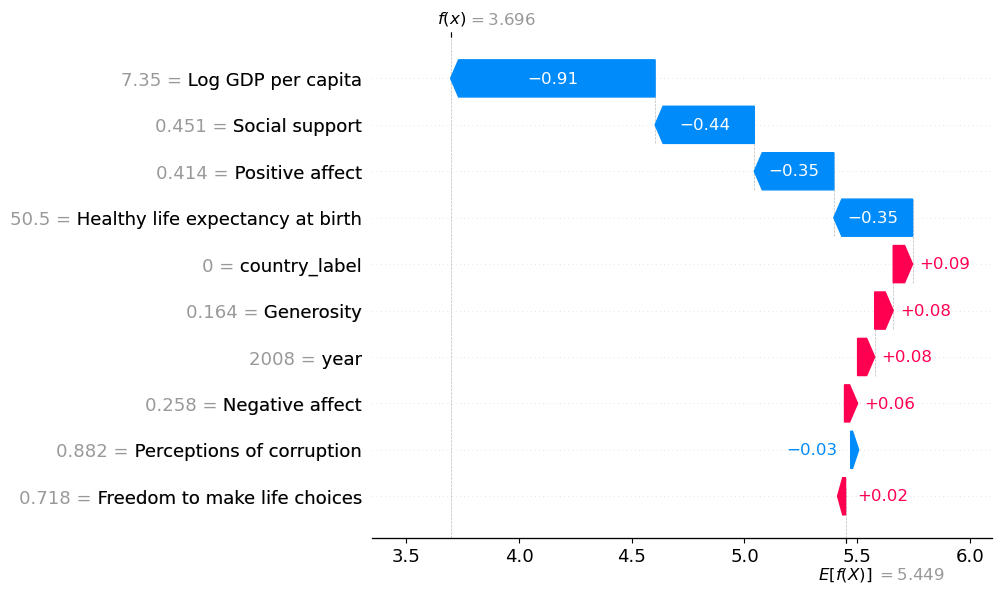

In [36]:
import lightgbm
from lightgbm import LGBMRegressor
import shap

model1 =lightgbm.LGBMRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model1)
shap_values = explainer(features_train)

shap.plots.waterfall(shap_values[0])


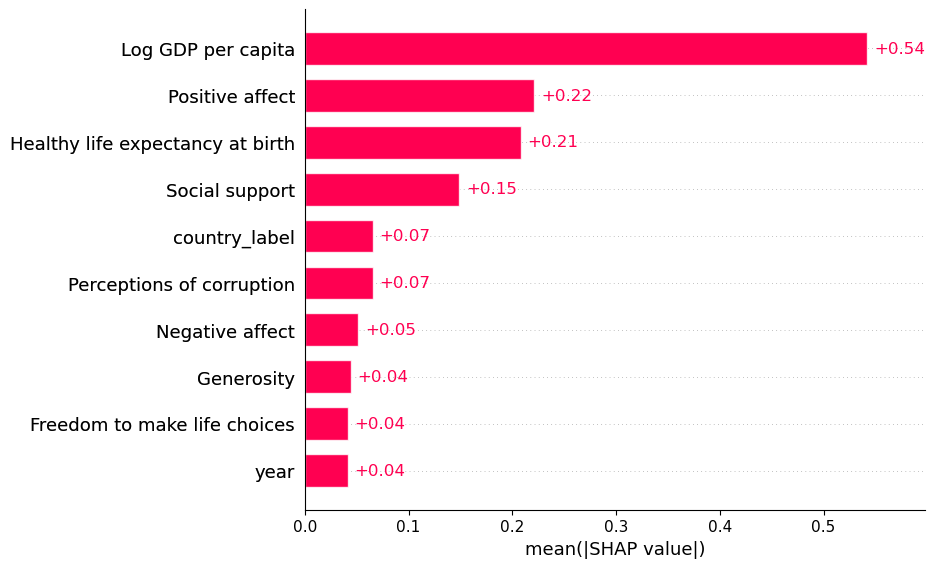

In [37]:
shap.plots.bar(shap_values)

In [38]:
features_test

,year,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
12,2021,7.325,0.454,54.550,0.394,-0.085,0.946,0.179,0.607,0
13,2022,7.325,0.228,54.875,0.368,-0.085,0.733,0.206,0.576,0
14,2023,7.325,0.368,55.200,0.228,-0.085,0.738,0.261,0.460,0
27,2020,9.494,0.710,69.125,0.754,0.002,0.891,0.563,0.265,1
28,2021,9.588,0.702,69.150,0.827,0.039,0.896,0.554,0.254,1
...,...,...,...,...,...,...,...,...,...,...
2344,2023,8.115,0.664,56.100,0.854,0.092,0.814,0.653,0.359,153
2359,2020,7.596,0.717,53.575,0.643,0.003,0.789,0.661,0.346,154
2360,2021,7.657,0.685,54.050,0.668,-0.079,0.757,0.610,0.242,154
2361,2022,7.670,0.666,54.525,0.652,-0.073,0.753,0.641,0.191,154


In [39]:

from IPython.display import Javascript

Javascript("""
alert('Hello from JavaScript!');
""")


<IPython.core.display.Javascript object>

In [40]:
#features_test = pd.DataFrame(features_test)

# feature_names = features_test.columns.names
# Calculating SHAP values
model2 = CatBoostRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model2)
shap_values = explainer(features_test)

Learning rate set to 0.044626
0:	learn: 1.0963346	total: 4.16ms	remaining: 4.16s
1:	learn: 1.0612144	total: 6.8ms	remaining: 3.39s
2:	learn: 1.0278523	total: 9.56ms	remaining: 3.18s
3:	learn: 0.9969295	total: 12.2ms	remaining: 3.04s
4:	learn: 0.9668442	total: 14.9ms	remaining: 2.97s
5:	learn: 0.9395862	total: 17.3ms	remaining: 2.87s
6:	learn: 0.9135088	total: 21.5ms	remaining: 3.05s
7:	learn: 0.8885151	total: 24.6ms	remaining: 3.05s
8:	learn: 0.8644008	total: 27.1ms	remaining: 2.98s
9:	learn: 0.8415540	total: 32.6ms	remaining: 3.23s
10:	learn: 0.8191188	total: 35.1ms	remaining: 3.16s
11:	learn: 0.7982412	total: 37.4ms	remaining: 3.08s
12:	learn: 0.7780339	total: 39.7ms	remaining: 3.02s
13:	learn: 0.7612855	total: 42.1ms	remaining: 2.96s
14:	learn: 0.7434443	total: 44.4ms	remaining: 2.92s
15:	learn: 0.7261445	total: 47.1ms	remaining: 2.9s
16:	learn: 0.7112221	total: 49.3ms	remaining: 2.85s
17:	learn: 0.6965188	total: 51.3ms	remaining: 2.8s
18:	learn: 0.6837074	total: 53.9ms	remaining: 2

In [41]:
shap.initjs()

In [42]:
features_test.value_counts

<bound method DataFrame.value_counts of       year  Log GDP per capita  Social support  \
12    2021               7.325           0.454   
13    2022               7.325           0.228   
14    2023               7.325           0.368   
27    2020               9.494           0.710   
28    2021               9.588           0.702   
...    ...                 ...             ...   
2344  2023               8.115           0.664   
2359  2020               7.596           0.717   
2360  2021               7.657           0.685   
2361  2022               7.670           0.666   
2362  2023               7.679           0.694   

      Healthy life expectancy at birth  Freedom to make life choices  \
12                              54.550                         0.394   
13                              54.875                         0.368   
14                              55.200                         0.228   
27                              69.125                         0.754   

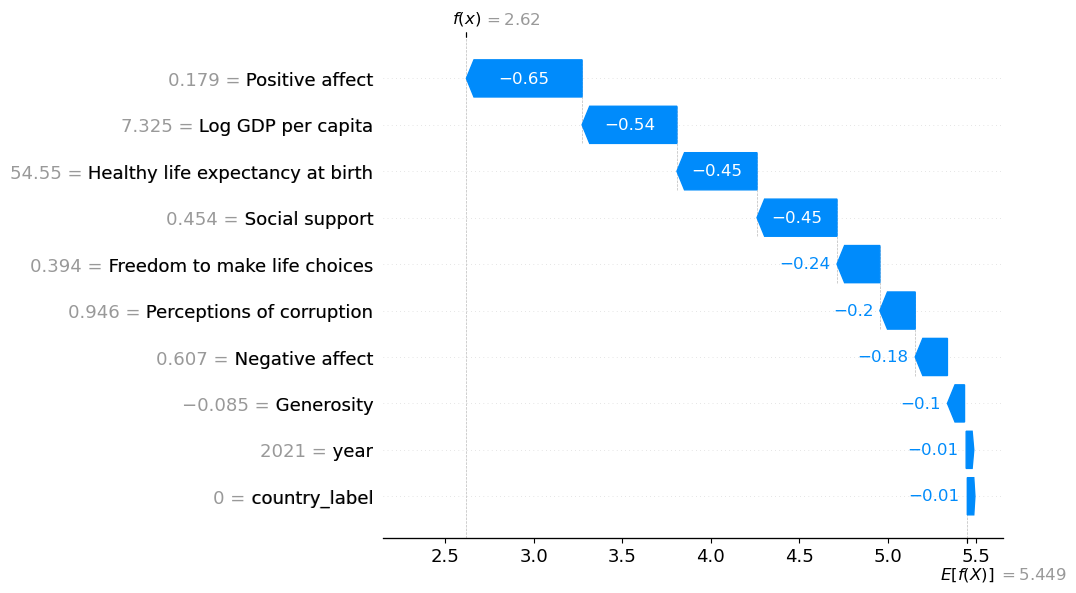

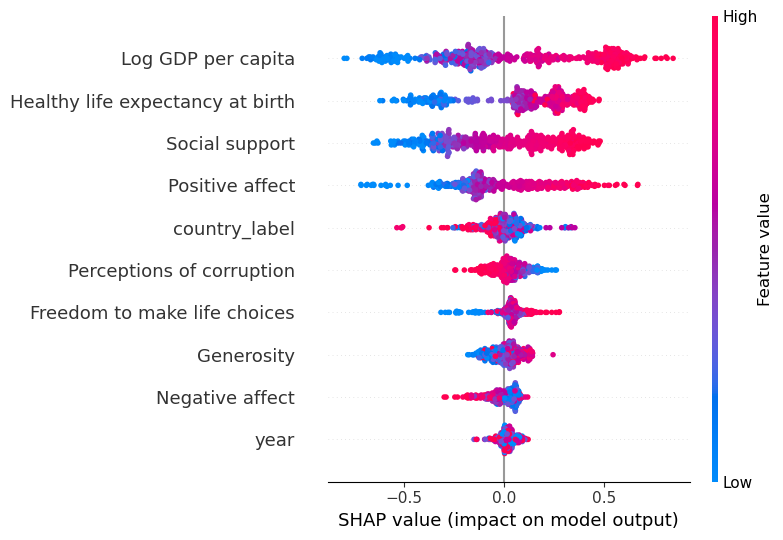

In [60]:


shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, features_test)

#Summarize the SHAP values for a specific prediction
# feature_names = features_test.columns.names

# shap.force_plot(explainer.expected_value, shap_values[0].values, features_test.iloc[0], feature_names = feature_names)


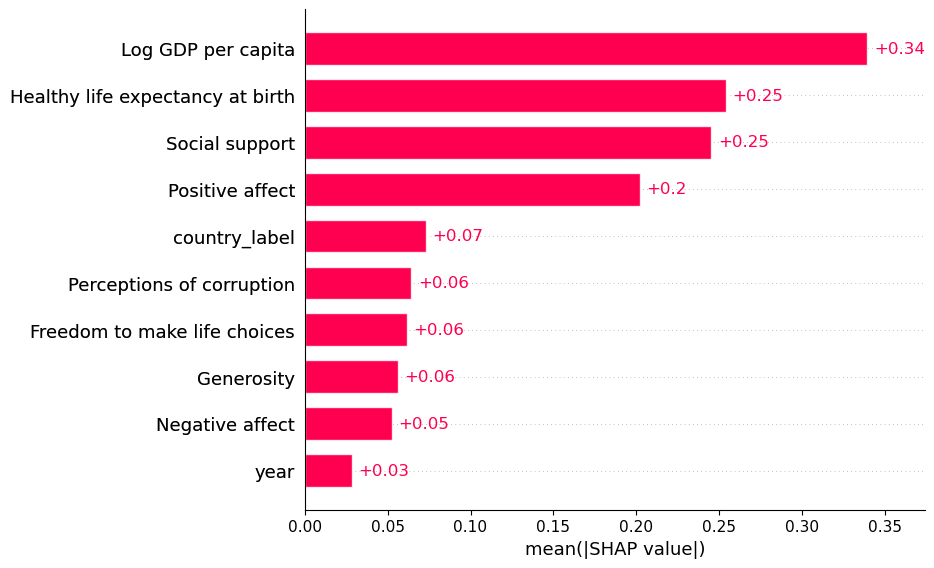

In [44]:
shap.plots.bar(shap_values)

In [45]:
count_fin = data[data['Country name']== 'Finland']
count_fin

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
665,Finland,2006,7.672,10.745,0.965,68.720,0.969,-0.011,0.132,0.683,0.172,46
666,Finland,2008,7.671,10.796,0.951,69.160,0.934,0.022,0.217,0.691,0.144,46
667,Finland,2010,7.393,10.734,0.935,69.600,0.916,0.085,0.413,0.758,0.202,46
668,Finland,2011,7.354,10.754,0.938,69.820,0.936,0.095,0.320,0.709,0.205,46
669,Finland,2012,7.420,10.735,0.928,70.040,0.921,-0.007,0.361,0.742,0.202,46
670,Finland,2013,7.445,10.722,0.941,70.260,0.919,0.034,0.306,0.752,0.195,46
671,Finland,2014,7.385,10.714,0.952,70.480,0.933,-0.007,0.265,0.766,0.199,46
672,Finland,2015,7.448,10.716,0.948,70.700,0.930,0.105,0.223,0.736,0.191,46
673,Finland,2016,7.660,10.741,0.954,70.775,0.948,-0.033,0.250,0.769,0.182,46
674,Finland,2017,7.788,10.770,0.964,70.850,0.962,-0.008,0.192,0.756,0.176,46


In [46]:
costa_row = training.index[training['Country name']=='Costa Rica'].tolist()[0]
print(costa_row)

473


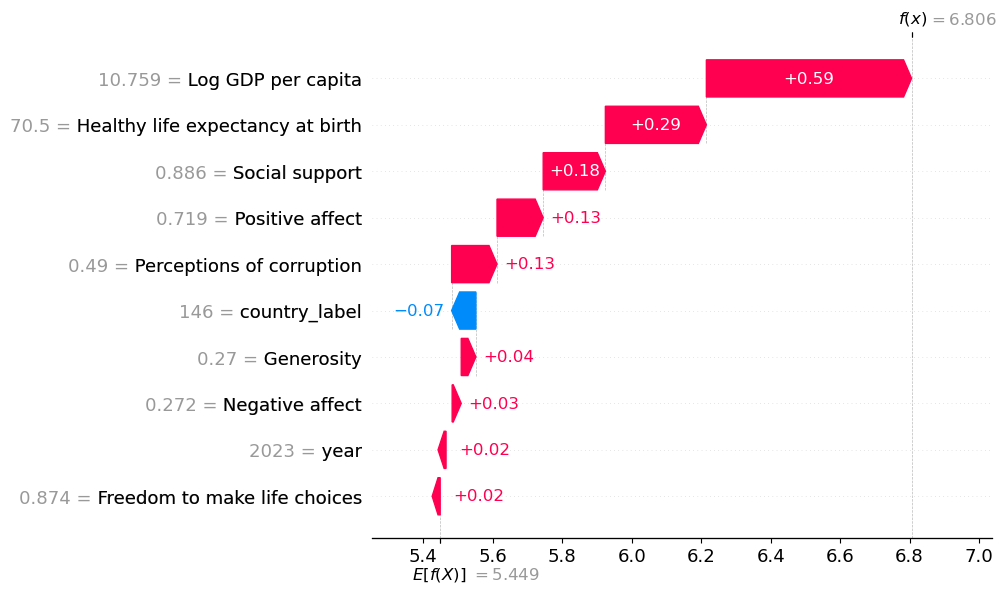

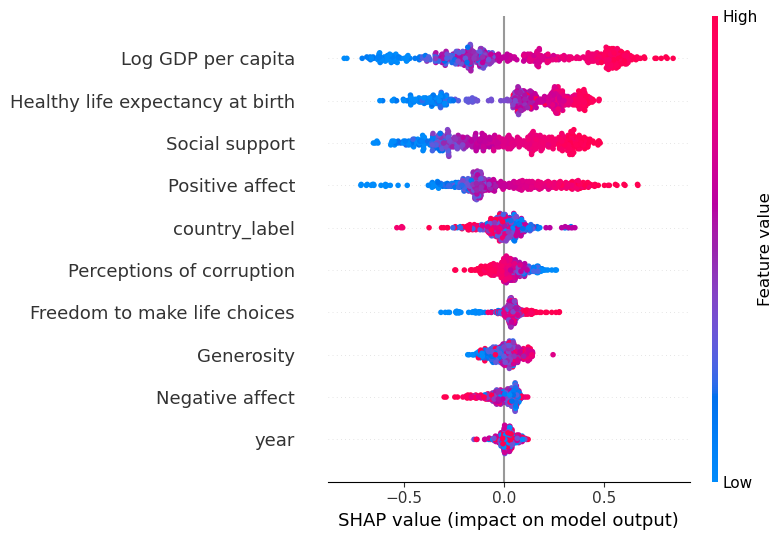

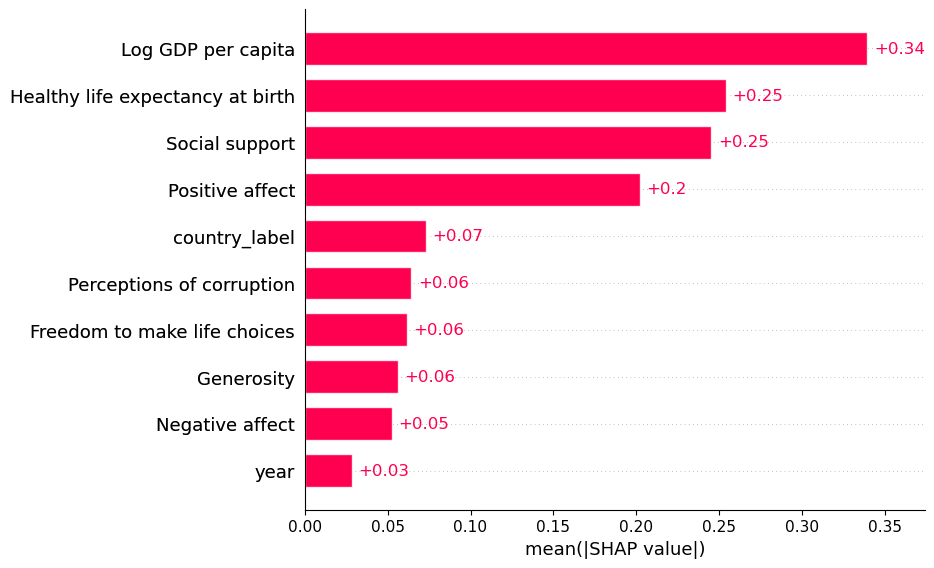

In [47]:

shap.plots.waterfall(shap_values[473])
shap.summary_plot(shap_values, features_test)
shap.plots.bar(shap_values)

In [48]:
print(features_test.iloc[473])

year                                2023.000
Log GDP per capita                    10.759
Social support                         0.886
Healthy life expectancy at birth      70.500
Freedom to make life choices           0.874
Generosity                             0.270
Perceptions of corruption              0.490
Positive affect                        0.719
Negative affect                        0.272
country_label                        146.000
Name: 2224, dtype: float64


In [49]:
features_test.tail(50)

,year,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
2151,2020,10.257,0.857,68.575,0.510,-0.119,0.774,0.332,0.440,142
2152,2021,10.357,0.736,68.750,0.447,-0.039,0.810,0.297,0.471,142
2153,2022,10.404,0.830,68.925,0.470,-0.195,0.767,0.311,0.390,142
2154,2023,10.429,0.860,69.100,0.523,-0.159,0.748,0.344,0.349,142
2169,2020,7.714,0.800,58.675,0.687,0.140,0.878,0.705,0.425,143
2170,2021,7.717,0.793,59.150,0.711,0.081,0.835,0.699,0.359,143
2171,2022,7.733,0.781,59.625,0.720,0.135,0.836,0.708,0.439,143
2172,2023,7.759,0.827,60.100,0.848,0.067,0.912,0.726,0.376,143
2187,2020,9.426,0.885,64.425,0.784,0.121,0.946,0.629,0.285,144
2188,2021,9.469,0.879,64.550,0.770,0.166,0.922,0.575,0.250,144


In [50]:
test.tail(50)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
2151,Türkiye,2020,4.862,10.257,0.857,68.575,0.510,-0.119,0.774,0.332,0.440,142
2152,Türkiye,2021,4.367,10.357,0.736,68.750,0.447,-0.039,0.810,0.297,0.471,142
2153,Türkiye,2022,5.093,10.404,0.830,68.925,0.470,-0.195,0.767,0.311,0.390,142
2154,Türkiye,2023,5.463,10.429,0.860,69.100,0.523,-0.159,0.748,0.344,0.349,142
2169,Uganda,2020,4.641,7.714,0.800,58.675,0.687,0.140,0.878,0.705,0.425,143
2170,Uganda,2021,4.225,7.717,0.793,59.150,0.711,0.081,0.835,0.699,0.359,143
2171,Uganda,2022,4.425,7.733,0.781,59.625,0.720,0.135,0.836,0.708,0.439,143
2172,Uganda,2023,4.467,7.759,0.827,60.100,0.848,0.067,0.912,0.726,0.376,143
2187,Ukraine,2020,5.270,9.426,0.885,64.425,0.784,0.121,0.946,0.629,0.285,144
2188,Ukraine,2021,5.311,9.469,0.879,64.550,0.770,0.166,0.922,0.575,0.250,144
